In [1]:
import numpy as np
import pynbody
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy.coordinates as coord
from matplotlib.colors import LogNorm
import scipy.ndimage
from nbodykit.lab import *
from nbodykit.source.catalog import ArrayCatalog
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import pandas as pd
from astropy.io import ascii
from scipy import stats

from astropy.coordinates.matrix_utilities import rotation_matrix
from pynbody.halo.rockstar import RockstarCatalogueOneCpu
import matplotlib.font_manager
import cmasher as cmr

mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2

#cosmetics
mpl.rc('text', usetex=True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [2]:
box_size = 512.
box_res = 256.
res = box_size/box_res
#Do general cosmo things
cosmo = FlatLambdaCDM(H0=100, Om0=0.315)
mass_res = cosmo.critical_density0.to(u.M_sun/u.Mpc**3)*(box_size*u.Mpc)**3/box_res**3*cosmo.Om(0.)

#get speed of light in km/s
ckms = 299792
velkms = (box_size/8677.2079486362706)*ckms

In [3]:
path = "/works/mata/COSMOS_SIMS2/NBODY/"
simdir = "RUN11_2980_256"

In [4]:
def plot_slice(dens,xg,yg,zg):
  start = 125
  end = 130
  cmap = plt.get_cmap('turbo')
  cmap = cmr.infinity

  #cmap.set_under("w")
  c = dens[start:end,:,:].mean(0)
  c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)  
  fac=4.
  fig = plt.figure(figsize=(fac*5.12, fac*1))
  ax = fig.add_subplot(111)
  im = ax.imshow((c).T,norm=LogNorm(),interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)
  ax.set_ylim([200,300]) 
  ax.set_xlabel(r"Line of Sight distance $[h^{-1} \, \rm{Mpc}]$",fontsize=22)
  ax.set_ylabel(r"Transverse distance$[h^{-1} \, \rm{Mpc}]$",fontsize=22)
  ax.tick_params(axis='x', labelsize=22)
  ax.tick_params(axis='y', labelsize=22)

  ax1 = ax.twiny()
  ax1.set_xlim(ax.get_xlim())
  new_tick_locations = np.array([30, 127, 220,308,392,473])
  ax1.set_xticks(new_tick_locations)
  ax1.set_xticklabels([2,2.1,2.2,2.3,2.4,2.5])
  ax1.set_xlabel(r"Observed redshift distance $z^{\rm obs}$",fontsize=22)
  ax1.tick_params(axis='x', labelsize=22)
  ax1.tick_params(axis='y', labelsize=22)


  ax1.scatter(xo,zo,s=200,marker='x',lw=3,color='black')


  side = 512.
  dd = side/256
  edge = 0
  start_gal = edge + start*dd
  end_gal = edge + end*dd
  coords = yg
  i_c = np.where((coords>start_gal)*(coords<end_gal))[0]
  plt.scatter(xg[i_c],zg[i_c],s=2,c='k',alpha=0.25)

  props = dict(boxstyle='round', facecolor='white', alpha=0.5,edgecolor='white')
  # place a text box in upper left in axes coords
  t = ax.text(0.05, 0.95, r"$z=$ "+str(2.3), transform=ax.transAxes, fontsize=22, color="black",verticalalignment='top', bbox=props)
  t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white',boxstyle='round'))
  #plt.savefig("/works/mata/COSMOS_SIMS2/NBODY/plots/dens_smooth.pdf", dpi=100, bbox_inches='tight')
  #plt.colorbar(im)
  plt.show()

def get_z_rockstar(h):
    z = round(1./h._head[0][3] -1,2)
    z = format(z, '.2f')
    return z


def read_pynbody(path_s,path_h):
    s = pynbody.load(path_s)
    s['pos'] = (s['pos']+0.5)*box_size
    s['pos'].units='Mpc'
    s['vel']*=velkms
    s['vel'].units='km s^-1'
    s['mass'] = mass_res.value
    s['mass'].units='Msol'
    h = RockstarCatalogueOneCpu(s,filename=path_h)
    tipsy = open(path_s,'rb')
    header_type = np.dtype([('time', '>f8'),('N', '>i4'), ('Dims', '>i4'), ('Ngas', '>i4'), ('Ndark', '>i4'), ('Nstar', '>i4'), ('pad', '>i4')])
    header = np.fromfile(tipsy,dtype=header_type,count=1)
    header = dict(zip(header_type.names,header[0])) 
    redshift = np.fabs(np.around(1/header['time'] -1,decimals = 2)) 
    return (s,h,redshift)




In [5]:
def plot_slice_big(dens,xg,yg,zg):
  start = 120
  end = 128
  cmap = plt.get_cmap('turbo')
  cmap = cmr.infinity
  c = dens[start:end,:,:].mean(0)
  c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)  
  fac=4.
  fig = plt.figure(figsize=(fac*5.12, fac*1))
  ax = fig.add_subplot(111)
  im = ax.imshow((c).T,norm=LogNorm(vmin=3E-2,vmax=3.5E1),interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)

  ax.set_ylim([200.01,299.99]) 
  ax.set_xlabel(r"Line of Sight distance $[h^{-1} \, \rm{Mpc}]$",fontsize=22)
  ax.set_ylabel(r"Transverse distance$[h^{-1} \, \rm{Mpc}]$",fontsize=22)
  ax.tick_params(axis='x', labelsize=22)
  ax.tick_params(axis='y', labelsize=22)

  ax1 = ax.twiny()
  ax1.set_xlim(ax.get_xlim())
  new_tick_locations = np.array([30, 127, 220,308,392,473])
  ax1.set_xticks(new_tick_locations)
  ax1.set_xticklabels([2,2.1,2.2,2.3,2.4,2.5])
  ax1.set_xlabel(r"Observed redshift distance $z^{\rm obs}$",fontsize=22)
  ax1.tick_params(axis='x', labelsize=22)
  ax1.tick_params(axis='y', labelsize=22)

  side = 512.
  dd = side/256
  edge = 0
  start_gal = edge + start*dd
  end_gal = edge + end*dd
  coords = yg
  i_c = np.where((coords>start_gal)*(coords<end_gal))[0]
  plt.scatter(xg[i_c],zg[i_c],s=500,facecolors="None", edgecolor='k',alpha=0.9,lw=3)

  props = dict(boxstyle='round', facecolor='white', alpha=0.5,edgecolor='white')
  # place a text box in upper left in axes coords
  t = ax.text(0.05, 0.95, r"$z=$ "+str(0.0), transform=ax.transAxes, fontsize=32, color="black",verticalalignment='top', bbox=props)
  t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white',boxstyle='round'))
  plt.savefig("/works/mata/COSMOS_SIMS2/NBODY/plots/dens_z0_halo.pdf", dpi=100, bbox_inches='tight')
  plt.show()

In [6]:
#load z=2.3
file_s = path+simdir+"/"+simdir+".00103"
file_h = path+simdir+"/halos/"+"halos_00103.0.bin"
s,h,redshift = read_pynbody(file_s,file_h)


#load z=0
file_s = path+simdir+"/"+simdir+".00500"
file_h = path+simdir+"/halos/"+"halos_00500.0.bin"
s0,h0,redshift0 = read_pynbody(file_s,file_h)



names = ['id', 'num_p', 'mvir', 'mbound_vir', 'rvir', 'vmax', 'rvmax', 'vrms', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'E', 'Spin', 'PosUncertainty', 'VelUncertainty', 'bulk_vx', 'bulk_vy', 'bulk_vz', 'BulkVelUnc', 'n_core', 'm200b', 'm200c', 'm500c', 'm2500c', 'Xoff', 'Voff', 'spin_bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'Rs', 'Rs_Klypin', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer',  'idx', 'i_so', 'i_ph', 'num_cp', 'mmetric']
tbl = ascii.read(path+simdir+"/halos/halos_00108.0.ascii",names=names)
tbl0 = ascii.read(path+simdir+"/halos/halos_00500.0.ascii",names=names)

/home/mata/anaconda3/lib/python3.8/site-packages/pynbody/snapshot/tipsy.py:129: RuntimeWarning: No readable param file in the run directory or parent directory: using defaults.
  warnings.warn(


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


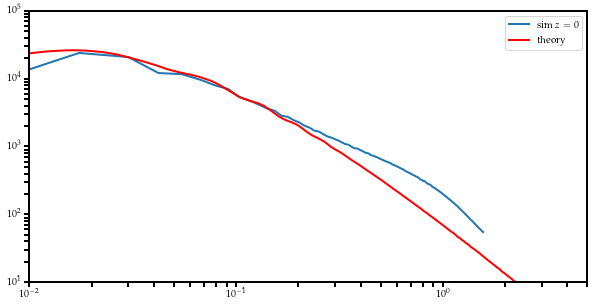

In [7]:
#Sanity Check
data = np.empty(256**3, dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
data['Position'] = s['pos']
data['Mass'] = s['mass']
f = ArrayCatalog(data)
f_mesh = f.to_mesh(Nmesh=256,BoxSize=512, resampler='cic', position='Position')
one_plus_delta = f_mesh.paint(mode='real')
dens = one_plus_delta.preview(Nmesh=256)


data0 = np.empty(256**3, dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
data0['Position'] = s0['pos']
data0['Mass'] = s0['mass']
f0 = ArrayCatalog(data0)
f0_mesh = f0.to_mesh(Nmesh=256,BoxSize=512, resampler='cic', position='Position')
one_plus_delta0 = f0_mesh.paint(mode='real')
dens0 = one_plus_delta0.preview(Nmesh=256)


r0 = FFTPower(f0_mesh, mode='1d')
pow0 = r0.power

k,p = np.loadtxt(path+'Pk.input_zinit_normalized_at_z0.DAT',unpack=True)

plt.figure(figsize=(10,5))
plt.plot(pow0['k'].real,pow0['power'].real,lw=2,label="sim $z=0$")

plt.plot(k,p,lw=2,color="r",label="theory")
plt.loglog()
plt.xlim(0.01,5)
plt.ylim(10,1E5)
plt.legend()

In [8]:
#auxiliary 

xg, yg, zg,_ = np.loadtxt(path+'central_cosmos_2-2p52xyz.txt',unpack=True)
xg-=3550
yg+=256
zg+=256


xo, yo, zo = np.loadtxt(path+'obs_cartesian.txt',unpack=True)
xo-=3550
yo+=256
zo+=256


xs, ys, zs = np.loadtxt(path+'sim_cartesian.txt',unpack=True)


In [9]:
data = np.empty(xg.size, dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
data['Position'] = np.dstack((xg,yg,zg))[0]
data['Mass'] = 1
f = ArrayCatalog(data)
f_mesh = f.to_mesh(Nmesh=256,BoxSize=512, resampler='cic', position='Position')
one_plus_delta = f_mesh.paint(mode='real')
dens_gal = one_plus_delta.preview(Nmesh=256)

<ipython-input-10-b2a8024f7a48>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under("w")


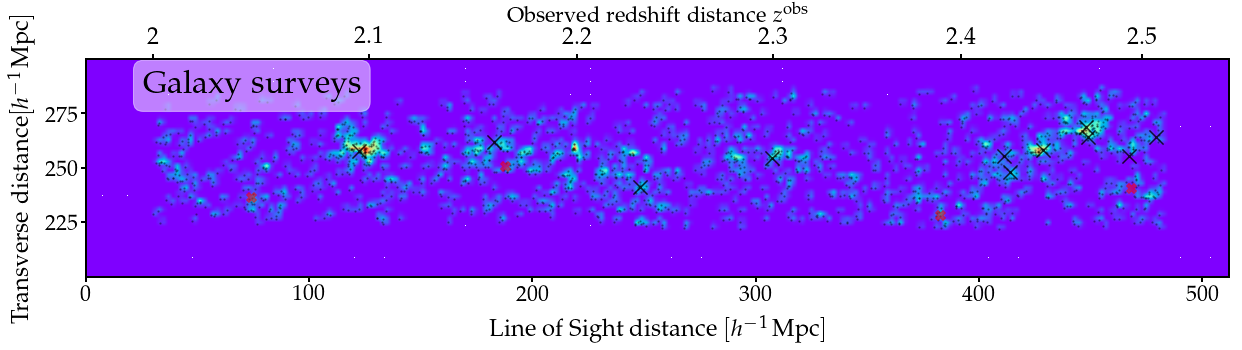

In [10]:
dens_gal_s = scipy.ndimage.gaussian_filter(dens_gal ,sigma=0.5/res,mode='wrap')

start = 90
end = 140
#cmap = cmr.infinity
#cmap.set_under("w")
cmap = plt.get_cmap('rainbow')
cmap.set_under("w")

#cgal = dens_gal[start:end,:,:].mean(0)
cgal = dens_gal_s[:,start:end,:].mean(1)
#cgal = dens_gal[:,:,start:end].mean(2)
side = 512.
dd = side/256
edge = 0
start_gal = edge + start*dd
end_gal = edge + end*dd
fac=4.
fig = plt.figure(figsize=(fac*5.12, fac*1))
ax = fig.add_subplot(111)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
im = ax.imshow((cgal+1).T,interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)
coords = yo
i_c = np.where((coords>start_gal)*(coords<end_gal))[0]
plt.scatter(xo[i_c],zo[i_c],s=200,c='k',marker="x",alpha=0.8)
ax.set_ylim([200.01,299.99]) 

coords = yg
i_c = np.where((coords>start_gal)*(coords<end_gal))[0]
plt.scatter(xg[i_c],zg[i_c],s=2,c='k',alpha=0.25)


coords = xs
i_c = np.where((coords>start_gal)*(coords<end_gal))[0]
plt.scatter(ys[i_c],zs[i_c],s=100,c='red',marker="X",alpha=0.5)



ax.set_ylim([200.01,299.99]) 

ax_ = ax.twiny()
ax_.set_xlim(ax.get_xlim())
new_tick_locations = np.array([30, 127, 220,308,392,473])
ax_.set_xticks(new_tick_locations)
ax_.set_xticklabels([2,2.1,2.2,2.3,2.4,2.5],fontsize=24)
ax_.set_xlabel(r"Observed redshift distance $z^{\rm obs}$",fontsize=22)
t = ax.text(0.05, 0.95, r"Galaxy surveys", transform=ax.transAxes, fontsize=32, color="black",verticalalignment='top')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white',boxstyle='round'))


fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel(r"Transverse distance$[h^{-1} \, \rm{Mpc}]$",fontsize=24,labelpad = 30)
plt.xlabel(r"Line of Sight distance $[h^{-1} \, \rm{Mpc}]$",fontsize=24,labelpad = 20)
#plt.savefig("/works/mata/COSMOS_SIMS2/NBODY/plots/gal_"+simdir+".pdf", dpi=50, bbox_inches='tight')
plt.show()

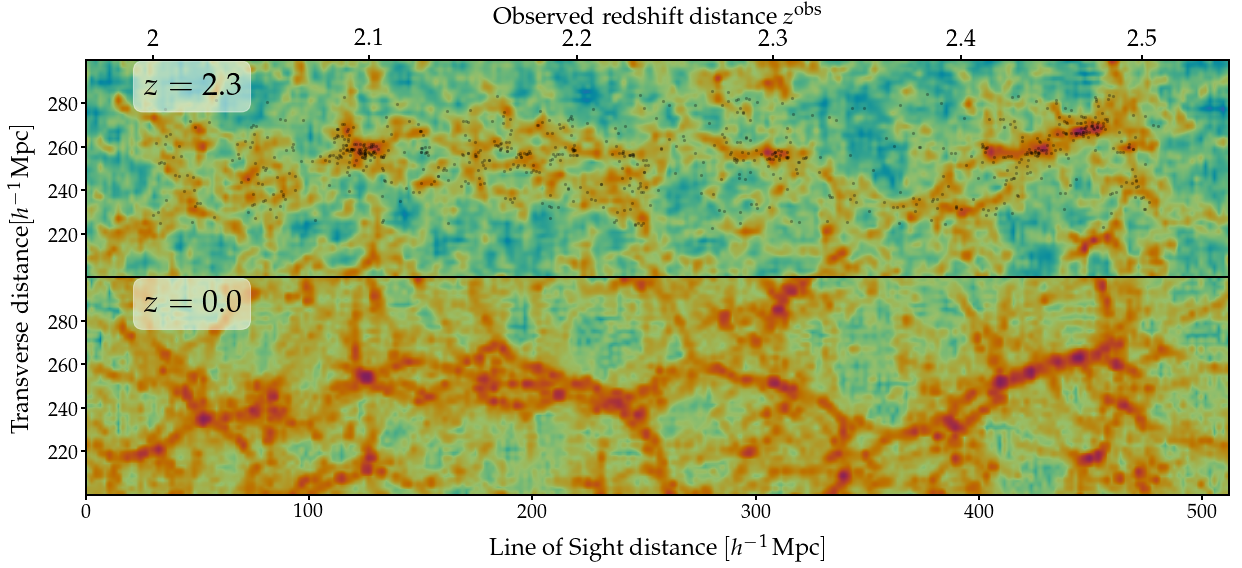

In [11]:
start = 122
end = 130
cmap = plt.get_cmap('turbo')
cmap = cmr.infinity
c = dens[start:end,:,:].mean(0)
c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2) 
c0 = dens0[start:end,:,:].mean(0)
c0 = scipy.ndimage.interpolation.zoom(c0 ,order=1, zoom=2) 
side = 512.
dd = side/256
edge = 0
start_gal = edge + start*dd
end_gal = edge + end*dd
coords = yg

i_c = np.where((coords>start_gal)*(coords<end_gal))[0]


fac = 4
fig, ax = plt.subplots(2, 1,figsize=(fac*5.12, fac*2))
plt.subplots_adjust(wspace=0.0, hspace=0)

[(i.tick_params(axis='y', labelsize=20),i.tick_params(axis='x', labelsize=20)) for i in ax]
ax[0].set_xticklabels([])
im1 = ax[0].imshow((c).T,norm=LogNorm(vmin=6E-2,vmax=2E1),interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)
ax[0].scatter(xg[i_c],zg[i_c],s=10,c='k',lw =0, alpha=0.3)
ax[0].set_ylim([200.1,299.9]) 

t = ax[0].text(0.05, 0.95, r"$z=$ "+str(2.3), transform=ax[0].transAxes, fontsize=32, color="black",verticalalignment='top')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white',boxstyle='round'))


im2 = ax[1].imshow((c0).T,norm=LogNorm(vmin=6E-4,vmax=2E2),interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)
ax[1].set_ylim([200.01,299.99]) 
ax_ = ax[0].twiny()
ax_.set_xlim(ax[0].get_xlim())
new_tick_locations = np.array([30, 127, 220,308,392,473])
ax_.set_xticks(new_tick_locations)
ax_.set_xticklabels([2,2.1,2.2,2.3,2.4,2.5],fontsize=24)
ax_.set_xlabel(r"Observed redshift distance $z^{\rm obs}$",fontsize=24)
t = ax[1].text(0.05, 0.95, r"$z=$ "+str(0.0), transform=ax[1].transAxes, fontsize=32, color="black",verticalalignment='top')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white',boxstyle='round'))


fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel(r"Transverse distance$[h^{-1} \, \rm{Mpc}]$",fontsize=24,labelpad = 30)
plt.xlabel(r"Line of Sight distance $[h^{-1} \, \rm{Mpc}]$",fontsize=24,labelpad = 20)
plt.savefig("/works/mata/COSMOS_SIMS2/NBODY/plots/"+simdir+".pdf", dpi=100, bbox_inches='tight')
plt.show()
#plt.tight_layout()


In [137]:
ii_in = np.where((tbl0['x']>210 ) *(tbl0['x']<290 ) *(tbl0['z']>210 ) *(tbl0['z']<290 ) *(tbl0['mvir']>=2E14 )  )[0]
tbl0_in = tbl0[ii_in]
#all halos in observed region at z=0
aaa = np.asarray(np.argsort(tbl0_in["mvir"])[::-1])

idd = tbl0_in[aaa]["id"]

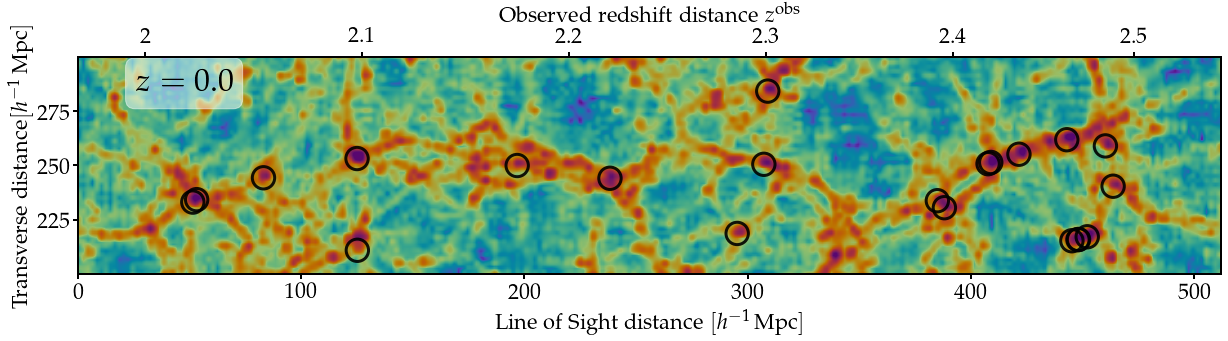

In [13]:
plot_slice_big(dens0,tbl0_in[aaa]['y'],tbl0_in[aaa]['x'],tbl0_in[aaa]['z'])

In [14]:
def center_of_mass(x,y,z,m):
    M = m.sum()
    X = (m*x).sum()
    Y = (m*y).sum()
    Z = (m*z).sum()
    XX = X/M
    YY = Y/M
    ZZ = Z/M 
    return(XX,YY,ZZ)

In [37]:
points_com = []
for i in idd:
    X,Y,Z  = center_of_mass(s["x"][h0._get_particles_for_halo(i)],s["y"][h0._get_particles_for_halo(i)],s["z"][h0._get_particles_for_halo(i)],s["mass"][h0._get_particles_for_halo(i)])
    points_com.append((X,Y,Z))
points_com = np.asarray(points_com)
 
from scipy.spatial import cKDTree
yy = np.concatenate((xo,ys))
xx = np.concatenate((yo,xs))
zz = np.concatenate((zo,zs))
points_obs = np.array((xx,yy,zz)).T # caution, x,y flipped wrt to sim frame
points_z0 = np.array((tbl0_in[aaa]['x'],tbl0_in[aaa]['y'],tbl0_in[aaa]['z'] )).T 
kdtree_obs = cKDTree(points_obs)
kdtree_z0 = cKDTree(points_z0)
kdtree_com = cKDTree(points_com)
indexes = kdtree_obs.query_ball_tree(kdtree_com, r=15)


In [38]:
len(indexes)

15

In [95]:
index = []

for i in indexes:
    if len(i)>1:
        i = [i[0]]
    index.append(i)
    

(225.0, 275.0)

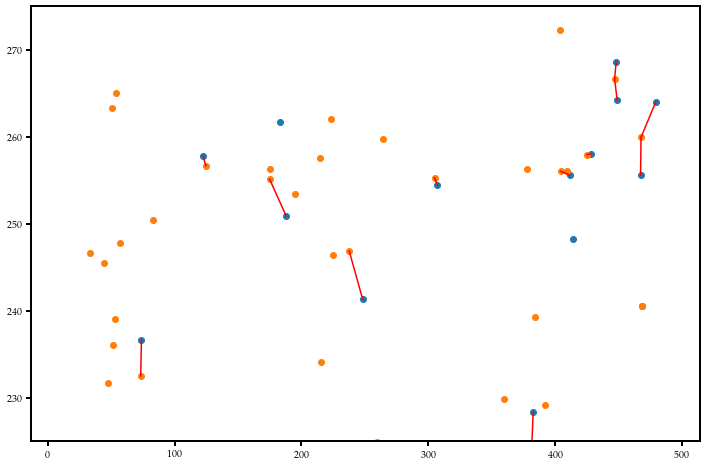

In [96]:
plt.figure(figsize=(12,8))
plt.scatter(points_obs[:,1],points_obs[:,2])
plt.scatter(points_com[:,1],points_com[:,2])

for i in range(len(index)):
    for j in index[i]:
        plt.plot([points_com[j, 1], points_obs[i, 1]],[points_com[j, 2],points_obs[i, 2]], "-r")

plt.ylim(225,275)

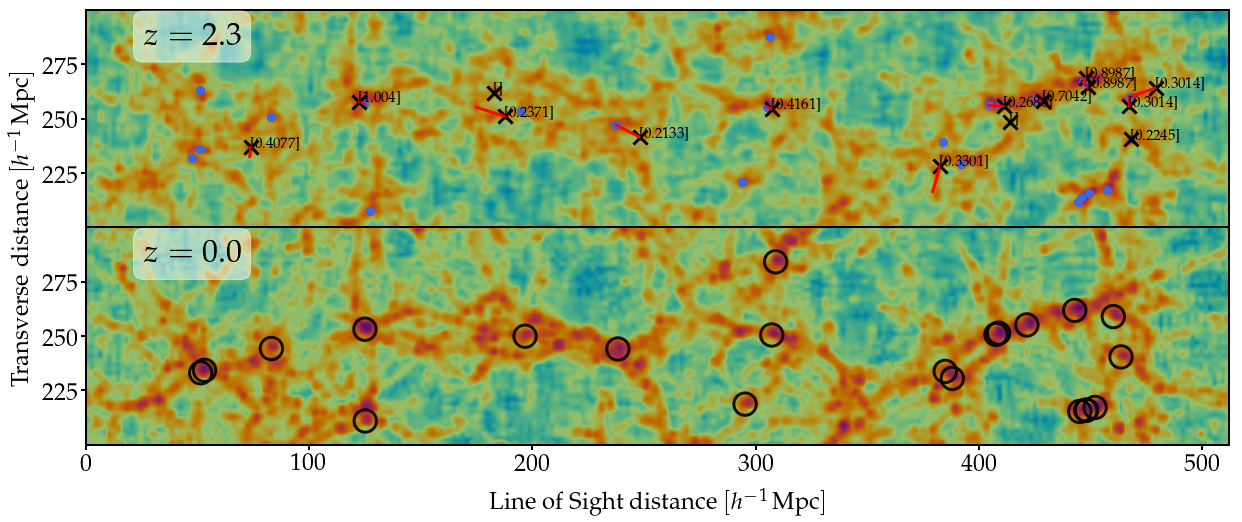

In [136]:

start = 119
end = 130
side = 512.
dd = side/256
edge = 0
start_gal = edge + start*dd
end_gal = edge + end*dd
c = dens[start:end,:,:].mean(0)
c = scipy.ndimage.interpolation.zoom(c,order=1, zoom=2) 

c0 = dens0[start:end,:,:].mean(0)
c0 = scipy.ndimage.interpolation.zoom(c0,order=1, zoom=2) 
coords = yg
i_c = np.where((coords>start_gal)*(coords<end_gal))[0]


fig, ax = plt.subplots(2, 1,figsize=(fac*5.12, fac*2))
plt.subplots_adjust(wspace=0.0, hspace=0)
[(i.tick_params(axis='y', labelsize=24),i.tick_params(axis='x', labelsize=24)) for i in ax]
ax[0].set_xticklabels([])

ax[0].set_xticklabels([])

im1 = ax[0].imshow((c).T,norm=LogNorm(vmin=1E-1,vmax=1E1),interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)

props = dict(boxstyle='round', facecolor='white', alpha=0.)
t = ax[0].text(0.05, 0.95, r"$z=$ "+str(2.3), transform=ax[0].transAxes, fontsize=32, color="black",verticalalignment='top')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white',boxstyle='round'))

for i in range(len(index)):
    for j in index[i]:
        ax[0].plot([points_com[j, 1], points_obs[i, 1]],[points_com[j, 2],points_obs[i, 2]], "-", c="red",lw=3,alpha=.95)
    
for i in range(len(idd)):
    id = idd[i]
    coords = points_com[:,0]
    i_c = np.where((coords>start_gal)*(coords<end_gal))[0]
    ax[0].scatter(points_com[:,1][i_c],points_com[:,2][i_c],c='royalblue',s=50,alpha=0.4)



ax[0].scatter(yy,zz,s=200,marker='x',lw=3,color='black')    
    
    
for i in range(len(yy)):
    ax[0].text(yy[i],zz[i],str(tbl0_in[aaa][index[i]]['mvir'].data/1E15),fontsize=15)
ax[0].set_ylim([200.1,299.9]) 




im0 = ax[1].imshow((c0).T,norm=LogNorm(vmin=1E-2,vmax=5E1),interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)
ax[1].set_ylim([200.01,299.99]) 


xh,yh,zh  = tbl0_in[aaa]['y'],tbl0_in[aaa]['x'],tbl0_in[aaa]['z']
coords = yh
i_c = np.where((coords>start_gal)*(coords<end_gal))[0]
ax[1].scatter(xh[i_c],zh[i_c],s=500,facecolors="None", edgecolor='k',alpha=0.9,lw=3)





t = ax[1].text(0.05, 0.95, r"$z=$ "+str(0.0), transform=ax[1].transAxes, fontsize=32, color="black",verticalalignment='top')
t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white',boxstyle='round'))


fig.add_subplot(111, frameon=False)

# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)

plt.ylabel(r"Transverse distance $[h^{-1} \, \rm{Mpc}]$",fontsize=24,labelpad = 30)
ax[1].set_xlabel(r"Line of Sight distance $[h^{-1} \, \rm{Mpc}]$",fontsize=24,labelpad = 10)

#plt.savefig("/works/mata/COSMOS_SIMS2/NBODY/plots/dens_match.pdf", dpi=100, bbox_inches='tight')
plt.savefig("/works/mata/COSMOS_SIMS2/NBODY/plots/match_numbers_"+simdir+".pdf", dpi=100, bbox_inches='tight')

plt.show()

